# Multimedia Security and Privacy
# TP 1
Tientso Ning

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import os

# 1. Introduction

(792, 1056, 3)


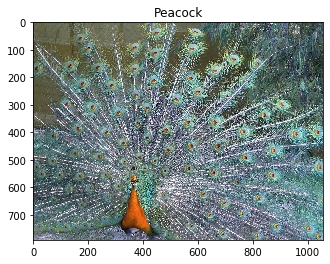

In [2]:
#read the image peacock.jpg
peacock = cv2.imread("./peacock.jpg")
plt.imshow(peacock)
plt.title("Peacock")
print(peacock.shape)

Text(0.5, 1.0, 'Histogram of Peacock')

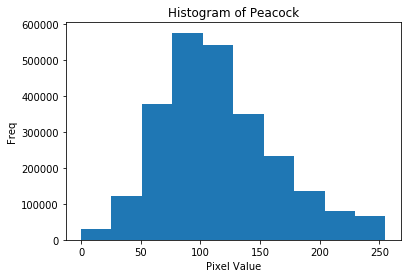

In [3]:
plt.hist(peacock.ravel())
plt.xlabel("Pixel Value")
plt.ylabel("Freq")
plt.title("Histogram of Peacock")

Text(0.5, 1.0, 'Peacock, but in Grey')

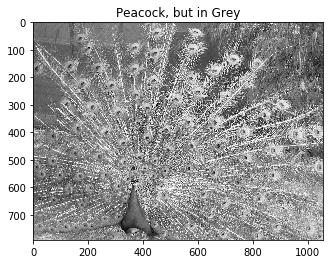

In [81]:
#convert the image to greyscale
peacockGRAY = cv2.cvtColor(peacock, cv2.COLOR_BGR2GRAY)
plt.imshow(peacockGRAY, cmap="Greys_r")
plt.title("Peacock, but in Grey")

In [5]:
#determine the global mean and global variance of the peacock
globmean = np.mean(peacockGRAY)
globvar = np.var(peacockGRAY)
print(globmean)
print(globvar)

118.77675667661462
2138.1369450172783


In [6]:
#cheat to find the local mean and variance
print(peacockGRAY.shape)
print(np.gcd(792, 1056))
#we can use block sizes of 33x33
window_size = (4,4)
print(tuple(np.array(peacockGRAY.shape) / window_size) + window_size)
peacockGRAYBLOCK = np.reshape(peacockGRAY, (198,4,264,4))

(792, 1056)
264
(198.0, 264.0, 4, 4)


Text(0.5, 1.0, 'Local Mean of Peacock')

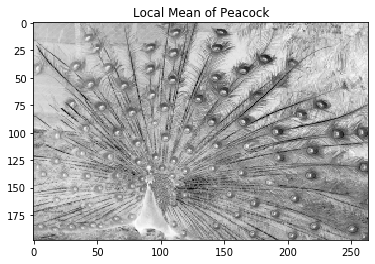

In [7]:
plt.imshow(np.mean(peacockGRAYBLOCK, axis=(1,3)), cmap = "Greys", aspect="auto")
plt.title("Local Mean of Peacock")

Text(0.5, 1.0, 'Local Variance of Peacock')

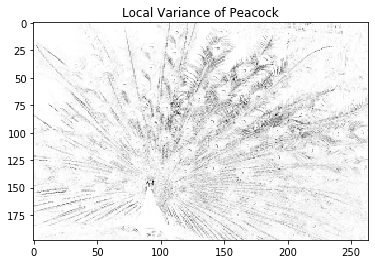

In [8]:
plt.imshow(np.var(peacockGRAYBLOCK, axis=(1,3)), cmap = "Greys", aspect="auto")
plt.title("Local Variance of Peacock")

It is important that we use distinct non-overlapping blocks since we are looking for the local mean of the individual blocks, which creates a sort of blur of the image. If we used overlapping blocks, we will start to see blocking artifacts in the image, and that might not be desirable. Additionally, it could mess with our process of comparing local means with global mean in the hashing process later on.

# 2. Noise

In [9]:
#generate an array of size NxM with Gaussian noise
def AWGN (N, M):
    '''
    Create an array of size N x M with Gaussian Noise
    '''
    return np.random.randn(N,M)

In [80]:
def SnPN (img, p, q):
    '''
    Takes an image and adds salt & pepper noise according to parameters p,q.
    '''
    
    out = np.copy(img)
    
    assert p + q <= 1 #need valid p,q values
    
    for i in range(0, out.shape[0]):
        for j in range(0, out.shape[1]):
            
            roll = np.random.random() #"I'll roll you for it!"

            if roll < p:
                out[i][j] = 0
            elif roll < q:
                out[i][j] = 255
            else:
                out[i][j] = out[i][j]
            
    return out

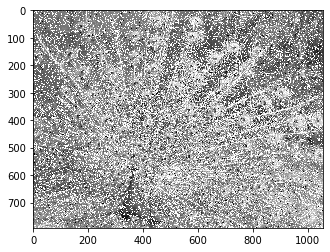

In [82]:
#test salt and pepper
salted = SnPN(peacockGRAY, 0.01, 0.21)
plt.imshow(salted, cmap="Greys_r")

In [84]:
def MSE (x, y):
    '''
    Determines the Mean Squared Error between images x and y
    '''
    assert x.shape == y.shape #same size or go home
    
    x = x.astype(float) #convert type
    
    z = (y-x)**2
    return np.mean(z)

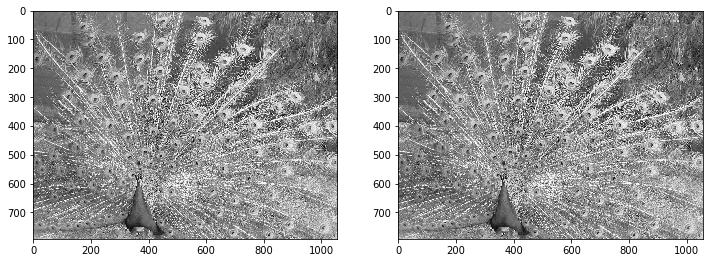

In [85]:
#read in a new copy of peacock
peacock_NEW = cv2.imread("./peacock.jpg", 0) #peacock but NEW
peacock_NEW_db = cv2.normalize(peacock_NEW.astype(float), None, 0.0, 1.0, cv2.NORM_MINMAX) #peacock but double
f, ax = plt.subplots(1,2, figsize=(12,24))
ax[0].imshow(peacock_NEW, cmap="Greys_r")
ax[1].imshow(peacock_NEW_db, cmap="Greys_r")

In [86]:
MSE(peacock_NEW, peacock_NEW_db) #"same" image but very high MSE!!

16128.447786022514

Although the image is the same, the scale used to portrait the images are different, and therefore the MSE (which takes into account distance via values) will be high. This is obviously not the intended effect, and could be remedied by normalizing, but still a factor we want to be cognizant of.

In [15]:
def PSNR (x, y, a):
    z = (a**2)/MSE(x,y)
    return 10*math.log10(z)

In [16]:
PSNR(peacock_NEW, peacock_NEW_db, 255)

6.054877882962412

In [17]:
#refactor the PSNR function so you can set PSNR and scale the AWGN
def refactor_PSNR(img, psnr, a):
    
    #determine sigma from psnr
    sigma = (a**2)/(10**(psnr/10))
    
    return img + (sigma*np.random.randn(img.shape[0],img.shape[1]))

21.859814424654328


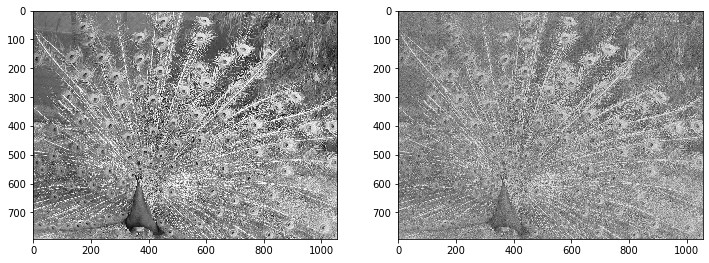

In [110]:
#test the refactor_PSNR
test1 = np.copy(peacockGRAY)
test2 = refactor_PSNR(test1, 35, 255)
f, ax = plt.subplots(1,2, figsize=(12,24))
ax[0].imshow(test1, cmap="Greys_r")
ax[1].imshow(test2, cmap="Greys_r")
print(PSNR(test1,test2,255))

In [33]:
#add gaussian noise to an image such that the PSNR ratio is 10,20,30,40
pcock10 = refactor_PSNR(peacockGRAY, 10, 255)
pcock20 = refactor_PSNR(peacockGRAY, 20, 255)
pcock30 = refactor_PSNR(peacockGRAY, 30, 255)
pcock40 = refactor_PSNR(peacockGRAY, 40, 255)

Text(0.5, 1.0, '40 dB')

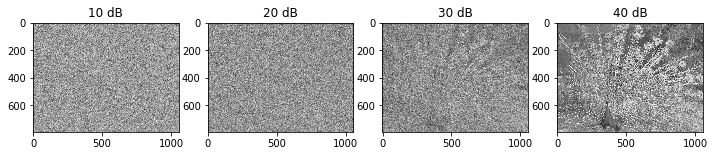

In [34]:
#show noisy images
f, ax = plt.subplots(1,4, figsize=(12,24))
ax[0].imshow(pcock10, cmap="Greys_r")
ax[1].imshow(pcock20, cmap="Greys_r")
ax[2].imshow(pcock30, cmap="Greys_r")
ax[3].imshow(pcock40, cmap="Greys_r")
ax[0].set_title("10 dB")
ax[1].set_title("20 dB")
ax[2].set_title("30 dB")
ax[3].set_title("40 dB")

As shown, the higher the PSNR ratio, the lower the MSE, which means that our image will resemble the original more.

Text(0.5, 1.0, '40 dB')

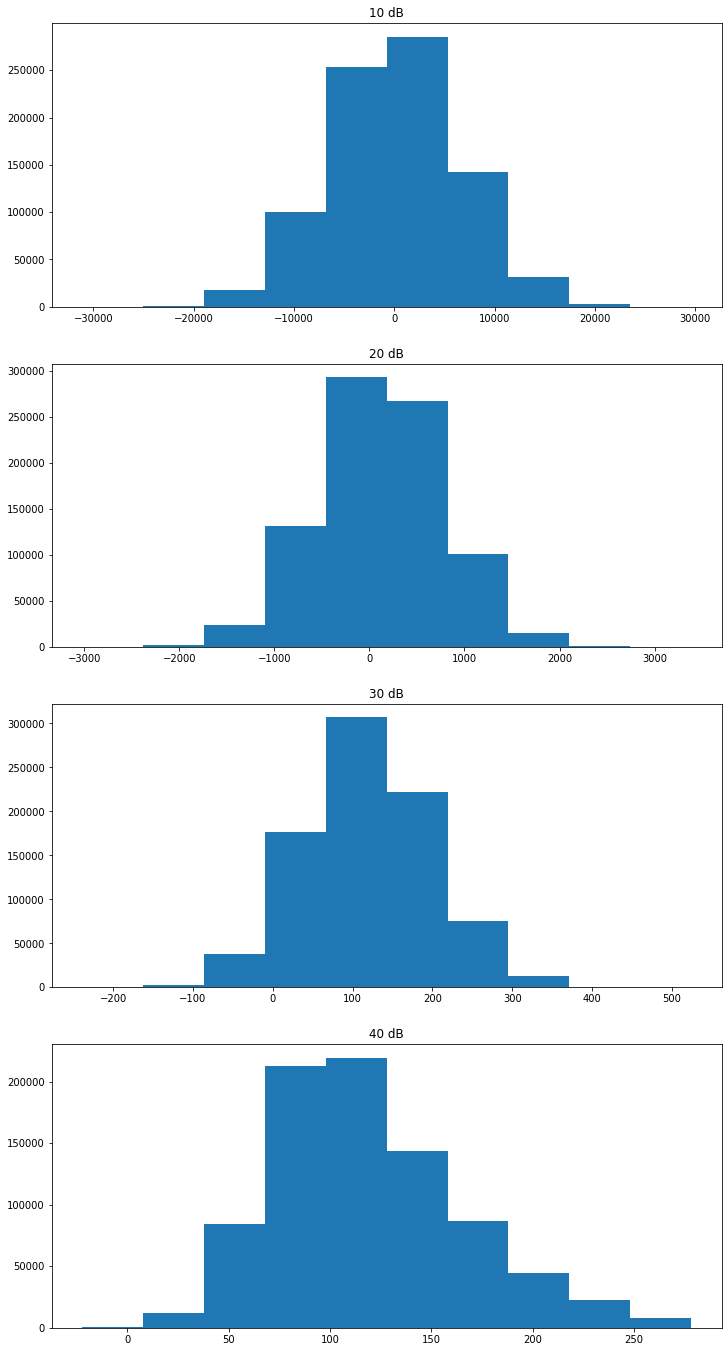

In [35]:
#show the histogram for noisy images
f, ax = plt.subplots(4,1, figsize=(12,24))
ax[0].hist(pcock10.ravel())
ax[1].hist(pcock20.ravel())
ax[2].hist(pcock30.ravel())
ax[3].hist(pcock40.ravel())
ax[0].set_title("10 dB")
ax[1].set_title("20 dB")
ax[2].set_title("30 dB")
ax[3].set_title("40 dB")

For the 10 and 20 PSNR ratios, we notice that the histogram shows the pixel values are closer to being centered around 0, meaning that the image is mostly just noise, whereas the 30 and 40 PSNR ratio histograms shows pixel values closer to the distribution seen originally.

In [92]:
#add salty and pepper noise to image until PSNR ratio is 40
og_img = np.copy(peacockGRAY)
psnr_val = 100
while(psnr_val > 40):
    imgPEPPERED = SnPN(og_img, 0.000082,0.0000145) #pepper em up nicely
    psnr_val = PSNR(peacockGRAY,imgPEPPERED,255) #calc psnr
    print(psnr_val)
    og_img = np.copy(imgPEPPERED) #set new

46.177972079144
43.291142779735
41.54957089692344
40.561387914728385
39.92502197189723


31.856609797951965
39.92502197189723


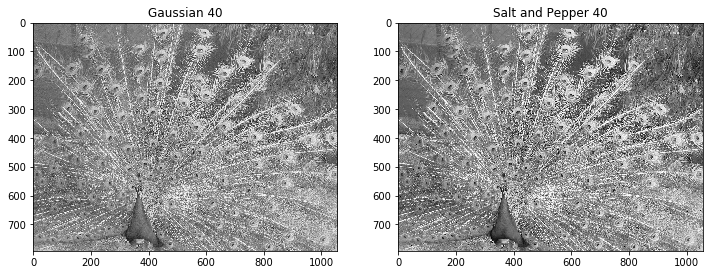

In [99]:
#see the difference
test1 = np.copy(pcock40)
test2 = np.copy(og_img)
f, ax = plt.subplots(1,2, figsize=(12,24))
ax[0].imshow(test1, cmap="Greys_r")
ax[1].imshow(test2, cmap="Greys_r")
ax[0].set_title("Gaussian 40")
ax[1].set_title("Salt and Pepper 40")
print(PSNR(test1,peacockGRAY,255))
print(PSNR(test2,peacockGRAY,255))

The images seem pretty similar, but this could be due to the fact that the PSNR value is closer to 31 for the Gaussian image as well as the fact that it is hard to detect changes in pixels for the salt and pepper image on the peacock since the peacock has such details on the image to begin with

# 3. Identification

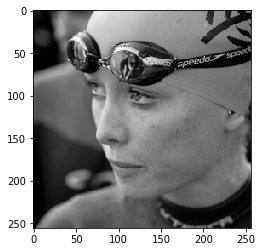

In [100]:
#read an image and convert to grayscale
img = cv2.imread("./images/dct_db/1_IMG_8059.tif", 0)
plt.imshow(img, cmap="Greys_r")

In [101]:
#determine the global mean of the image
gmean = np.mean(img)
print(gmean)

82.87767028808594


(8.0, 8.0, 32, 32)


Text(0.5, 1.0, 'Local Mean 32x32 block')

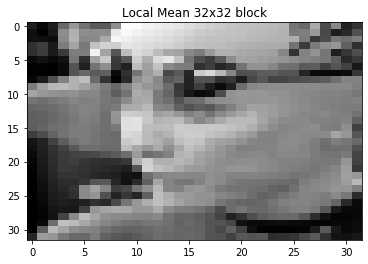

In [102]:
#we can use block sizes of 32x32
window_size = (32,32)
print(tuple(np.array(img.shape) / window_size) + window_size)
imgBLOCKED = np.reshape(img, (32,8,32,8))
plt.imshow(np.mean(imgBLOCKED, axis=(1,3)), cmap = "Greys_r", aspect="auto")
plt.title("Local Mean 32x32 block")

In [104]:
#determine local mean > global mean
def create_hash (img, g):
    
    blocked = np.mean(np.reshape(img, (32,8,32,8)), axis=(1,3))
    
    hashbrown = []
    for i in blocked.flatten():
        if i > g:
            hashbrown.append(1)
        else:
            hashbrown.append(0)
    return hashbrown

#use create_hash on imgBLOCKED
img_hash = create_hash(img, gmean)
print(img_hash)
print(len(img_hash))

[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 

In [105]:
#determiner obtains the descriptor (hamming distance h) and probability of error
def determiner (v1, v2):
    '''
    Determine the hamming distance h and probability of error p_b between two binary vectors
    '''
    assert len(v1) == len(v2)
    
    h = sum(np.logical_and(v1,v2))
    p_b = h/len(v1)
    
    return h, p_b

In [120]:
#read all images in the directory and save the hashes (images stored separately)
hash_store = []
batch = []
for filename in os.listdir("./images/dct_db/"):
    img = cv2.imread(os.path.join("./images/dct_db/",filename),0)
    if img is not None:
        hash_store.append(create_hash(img,np.mean(img))) #store hash
        batch.append(img)
print(len(hash_store))

200


In [121]:
#implement function takes images, copies, and distorts with AWGN until psnr of ~35
def distort_batch (batch):
    '''
    takes images, copies them and distorts the copies with AWGN until psnr of ~35
    '''
    ret_batch = []
    
    for item in batch:
        cop = np.copy(item) #copy 
        cop = refactor_PSNR(cop, 40, 255) #distort
        ret_batch.append(cop)
    return ret_batch

In [122]:
#determine the batch and distorted batch
distorted = distort_batch(batch)
print(len(distorted),len(batch))

200 200


In [123]:
#store hashes of distorted
distorted_hash_store = []
for i in range(0, len(distorted)):
    distorted_hash_store.append(create_hash(distorted[i],np.mean(distorted[i])))
print(len(distorted_hash_store))
    
#determine the hamming distance and p_b values between batch and distorted batch
assert len(batch) == len(distorted)
interclass_pb = []
for i in range(0, len(hash_store)):
    h, pb = determiner(hash_store[i],distorted_hash_store[i])
    interclass_pb.append(pb)
print(len(interclass_pb))
    

200
200


Text(0, 0.5, 'Frequency')

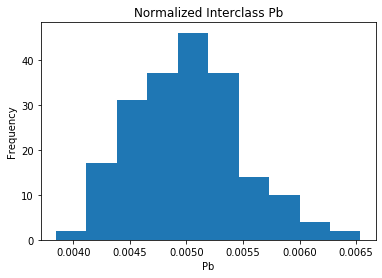

In [128]:
#show the histogram of p_b values

#normalize
from scipy.special import softmax
norm_ic_pb = softmax(interclass_pb)

plt.hist(norm_ic_pb)
plt.title("Normalized Interclass Pb")
plt.xlabel("Pb")
plt.ylabel("Frequency")

We can see that the distribution of Probability of error centers around 0.005, which means that we have a really low probability of error

In [130]:
#build a normalized histogram of all found P_b values between different classes
intraclass_pb = []
for i in range(0, len(hash_store)):
    for j in range(i, len(hash_store)):
        if i==j:
            pass
        else:
            h, pb = determiner(hash_store[i], hash_store[j])
            intraclass_pb.append(pb)
print(len(intraclass_pb))

19900


5.025125628140707e-05


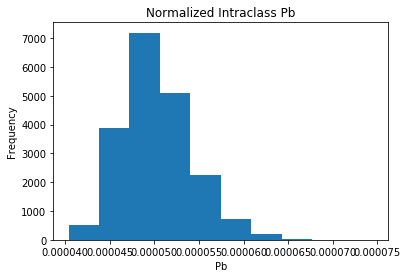

In [132]:
norm_intra_pb = softmax(intraclass_pb)
plt.hist(norm_intra_pb)
plt.title("Normalized Intraclass Pb")
plt.xlabel("Pb")
plt.ylabel("Frequency")
print(np.mean(norm_intra_pb))

We notice that the distribution of Pb centers around 0.00005, meaning that we're pretty certain that the images have no connection to each other.

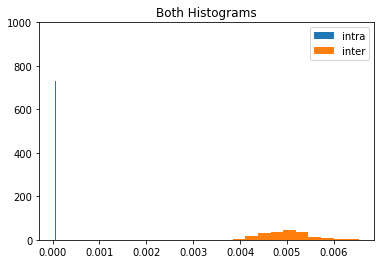

In [143]:
plt.hist(norm_intra_pb, label='intra')
plt.hist(norm_ic_pb, label='inter')
plt.ylim(0, 1000)
plt.legend()
plt.title("Both Histograms")
plt.show()

We can see from the histogram above that the two do not really overlap. We can conclude that we can make a pretty good separation between the two classes, meaning that we can reasonably determine images and which class they belong in (even when we distort these images slightly)